<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>

# Preprocesamiento de Datos para un Modelo de Clasificación

Nuestro equipo de riesgo ha identificado la necesidad de construir un modelo de clasificación para detectar transacciones potencialmente fraudulentas o anómalas. El éxito de este modelo permitirá identificar patrones en los datos y reducir pérdidas económicas para nuestros clientes y la empresa. Tu trabajo para hoy será preparar los datos proporcionados para desarrollar un modelo de clasificación que prediga la probabilidad de que una transacción sea “Normal” o “Anómala”, basándose en las características de las transacciones. Dentro de las tareas que tienes que realizar hoy deben estar incluidas las siguientes: 


1. **Análisis exploratorio de datos (EDA):**

   - Visualizar la distribución de las principales variables.

   - Explorar relaciones entre las características y la variable objetivo (`TransactionStatus`).


2. **Limpieza de datos:**

   - Identificar y tratar valores nulos.

   - Eliminar duplicados si existen.

   - Asegurar que las variables tienen el tipo de dato correcto.

   - etc. 

3. **Transformación de variables:**

   - Normalizar o escalar variables numéricas según sea necesario.

   - Codificar variables categóricas con técnicas como One-Hot Encoding, Target Encoding u Ordinal Encoding, según corresponda.

   - Crear variables derivadas útiles, como:

     - Frecuencia de transacciones de cada cliente.

     - Diferencia de tiempo entre transacciones consecutivas.

     - Ratio entre el saldo posterior y el monto de la transacción.

## Datos Proporcionados

El archivo de datos que analizarán contiene transacciones reales registradas por una compañia. A continuación, se describen las principales columnas que deberán preprocesar:

| Columna               | Descripción                                                                                     |
|-----------------------|-------------------------------------------------------------------------------------------------|
| `transaction_id`      | Identificador único de la transacción.                                                         |
| `customer_id`         | Identificador único del cliente que realizó la transacción.                                    |
| `merchant_id`         | Identificador único del comercio donde se realizó la transacción.                              |
| `amount`              | Monto de la transacción (en la moneda correspondiente).                                        |
| `transaction_time`    | Fecha y hora exacta en la que ocurrió la transacción.                                          |
| `is_fraudulent`       | Indicador de si la transacción fue fraudulenta (1: Sí, 0: No).                                 |
| `card_type`           | Tipo de tarjeta utilizada para la transacción (Visa, MasterCard, American Express, Discover).  |
| `location`            | Ubicación (ciudad o región) donde se realizó la transacción.                                   |
| `purchase_category`   | Categoría de la compra (por ejemplo, Gas Station, Online Shopping, Retail, etc.).              |
| `customer_age`        | Edad del cliente en el momento de la transacción.                                              |
| `transaction_description` | Descripción breve de la transacción, usualmente incluye el comercio asociado.              |


In [1]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np
import os 
import sys
sys.path.append("../")
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:

# Importamos las clases creadas para hace el EDA
from src import soporte_logistica_preprocesamiento as sl
from src import soporte_encoding_logistica as se
from src import soporte_encoding_logistica as sc
from src import  soporte_ajuste_logistica as sal


# Ignorar warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

# Imputación de nulos usando métodos avanzados estadísticos
# -----------------------------------------------------------------------
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler, RobustScaler
from category_encoders import TargetEncoder
from category_encoders import OneHotEncoder


In [3]:
# leemos el dataframe
df = pd.read_csv("datos/financial_data.csv", index_col = 0)
df.head(2)

,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
transaction_id,,,,,,,,,,
1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053


In [4]:
# llamamos a la función para hacer el análisis exploratorio de datos, para familiarizarnos con la estructura de los datos
sl.exploracion_datos(df)

El número de filas es 10000 y el número de columnas es 10

----------

En este conjunto de datos tenemos 0 valores duplicados

----------

Los columnas con valores nulos y sus porcentajes son: 


Series([], dtype: float64)


----------

Las principales estadísticas de las variables númericas son:


,count,mean,std,min,25%,50%,75%,max
customer_id,10000.0,1051.272300,28.864062,1001.00,1026.000,1052.000,1076.0000,1100.00
merchant_id,10000.0,2050.486600,28.877801,2001.00,2025.000,2050.000,2076.0000,2100.00
amount,10000.0,4958.381617,2899.699675,10.61,2438.175,4943.945,7499.3125,9999.75
is_fraudulent,10000.0,0.506800,0.499979,0.00,0.000,1.000,1.0000,1.00
customer_age,10000.0,44.047500,15.321707,18.00,31.000,44.000,57.0000,70.00



----------

Las principales estadísticas de las variables categóricas son:


,count,unique,top,freq
transaction_time,10000,10000,2023-01-01 02:46:23,1
card_type,10000,4,Discover,2633
location,10000,50,City-7,223
purchase_category,10000,6,Travel,1694
transaction_description,10000,100,Purchase at Merchant-2016,120



----------

Las características principales del dataframe son:
<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              10000 non-null  int64  
 1   merchant_id              10000 non-null  int64  
 2   amount                   10000 non-null  float64
 3   transaction_time         10000 non-null  object 
 4   is_fraudulent            10000 non-null  int64  
 5   card_type                10000 non-null  object 
 6   location                 10000 non-null  object 
 7   purchase_category        10000 non-null  object 
 8   customer_age             10000 non-null  int64  
 9   transaction_description  10000 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 859.4+ KB


None

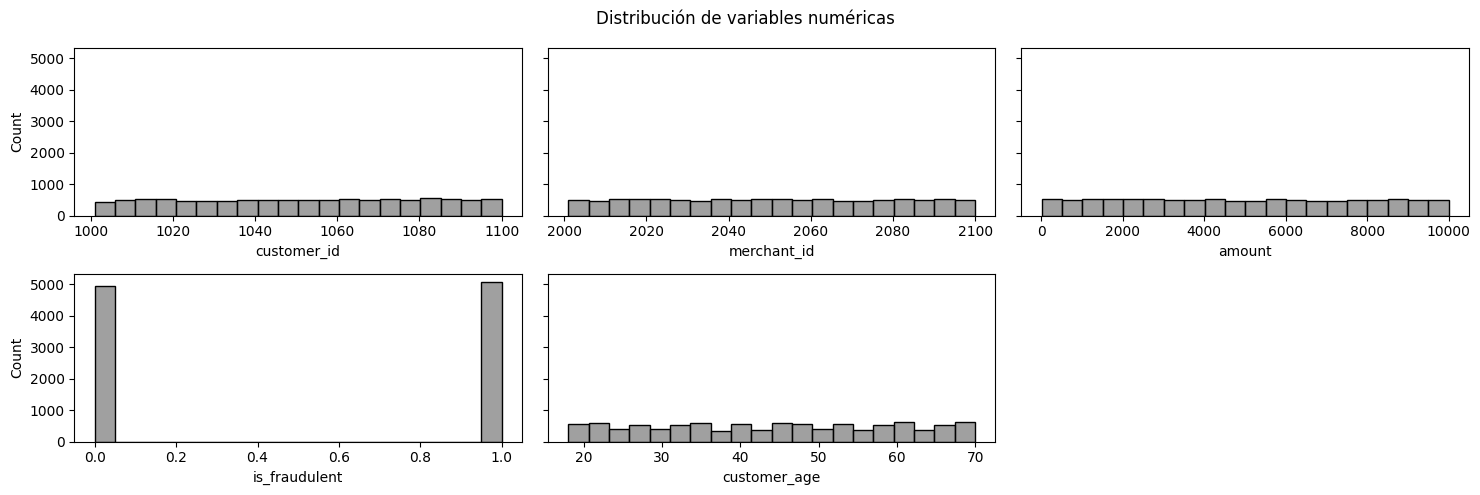

In [5]:
# Crear una instancia de la clase y llamar a los métodos
visualizador =sl.Visualizador(df)

# exploramos la distribución de las variables numéricas
visualizador.plot_numericas()

In [6]:
df.drop(columns=['transaction_time'],inplace=True)

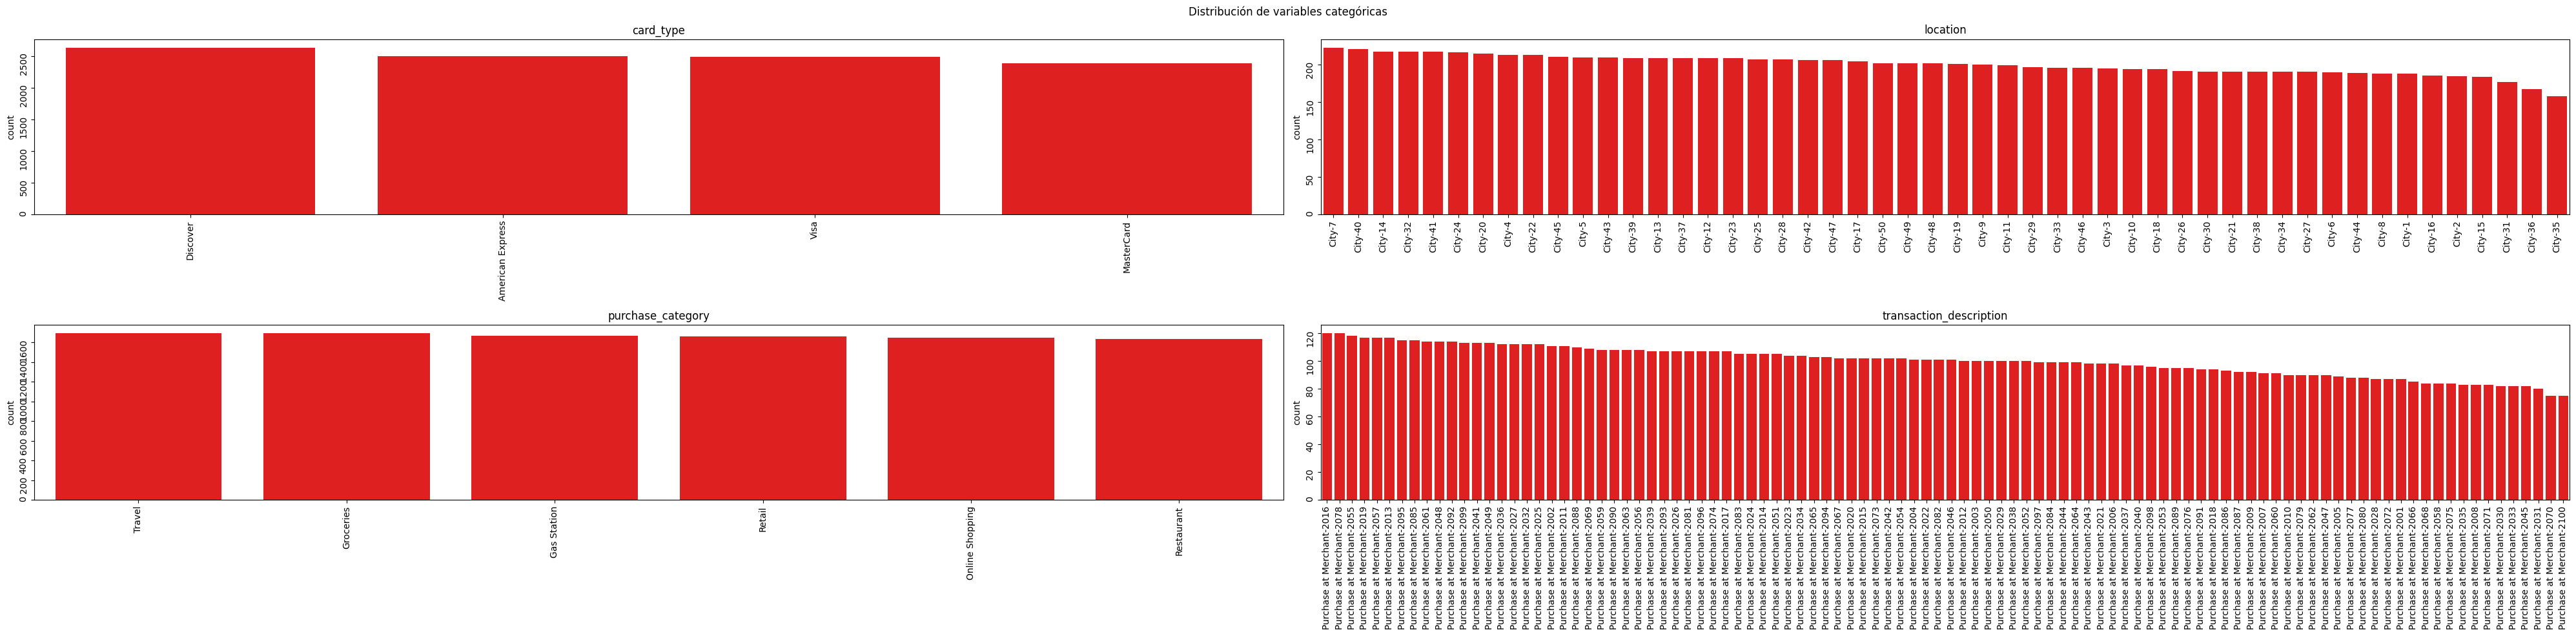

In [7]:
# evaluamos la distribución de las variables categóricas
visualizador.plot_categoricas(color = "red")

In [8]:
df.columns.unique()

Index(['customer_id', 'merchant_id', 'amount', 'is_fraudulent', 'card_type',
       'location', 'purchase_category', 'customer_age',
       'transaction_description'],
      dtype='object')

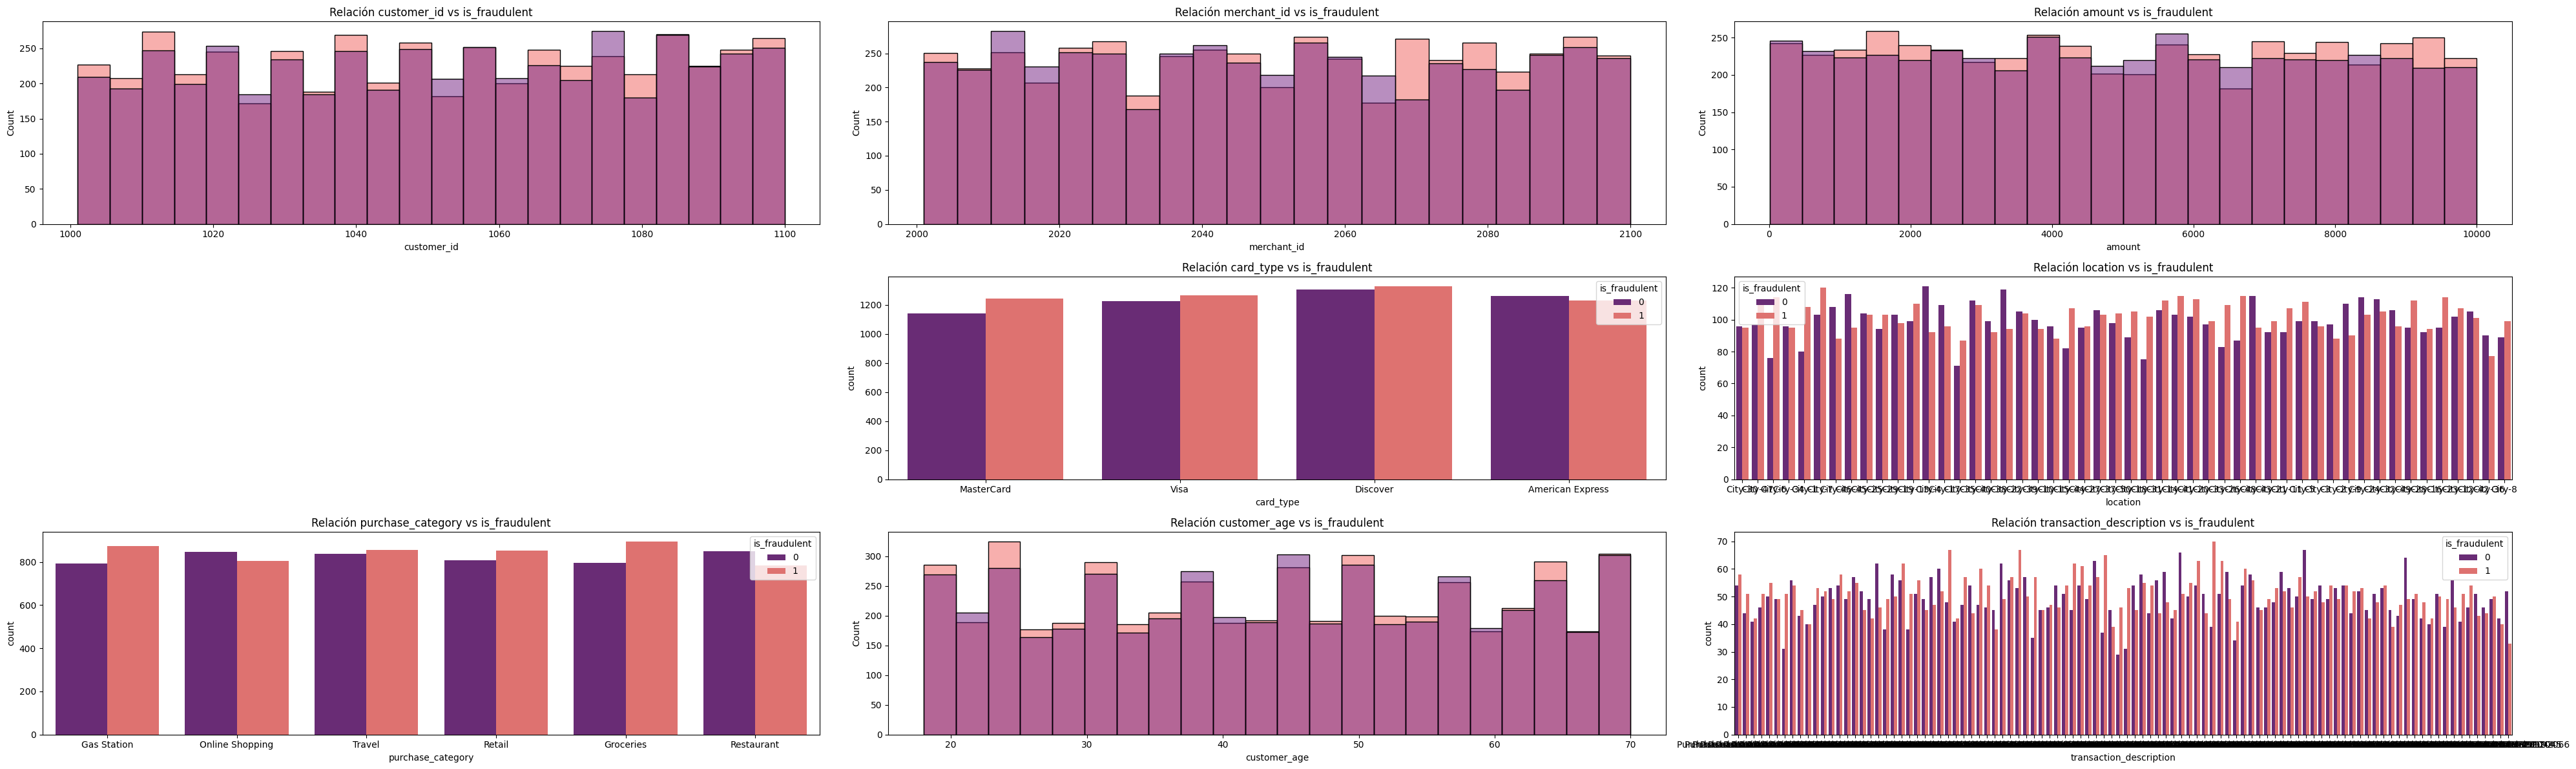

In [9]:
# evaluamos la relación entre las variables independientes y dependientes
visualizador.plot_relacion(vr = "is_fraudulent")

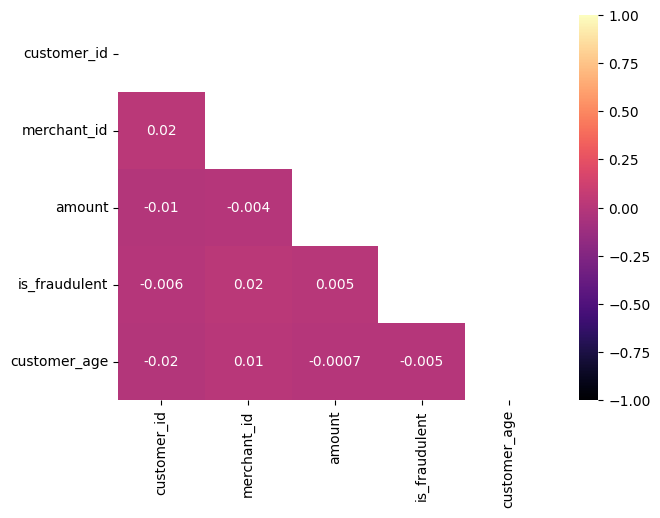

In [10]:
# evaluamos las correlaciones entre las variables numéricas
visualizador.correlacion()

In [11]:
columnas_numericas = df.select_dtypes(include=['number']).columns
columnas_numericas

Index(['customer_id', 'merchant_id', 'amount', 'is_fraudulent',
       'customer_age'],
      dtype='object')

In [12]:
escalador_robust = RobustScaler()
datos_transf_robust = escalador_robust.fit_transform(df[['customer_id','merchant_id','amount','customer_age']])
df[['customer_id','merchant_id','amount','customer_age']]  = datos_transf_robust       #Estandarizacion

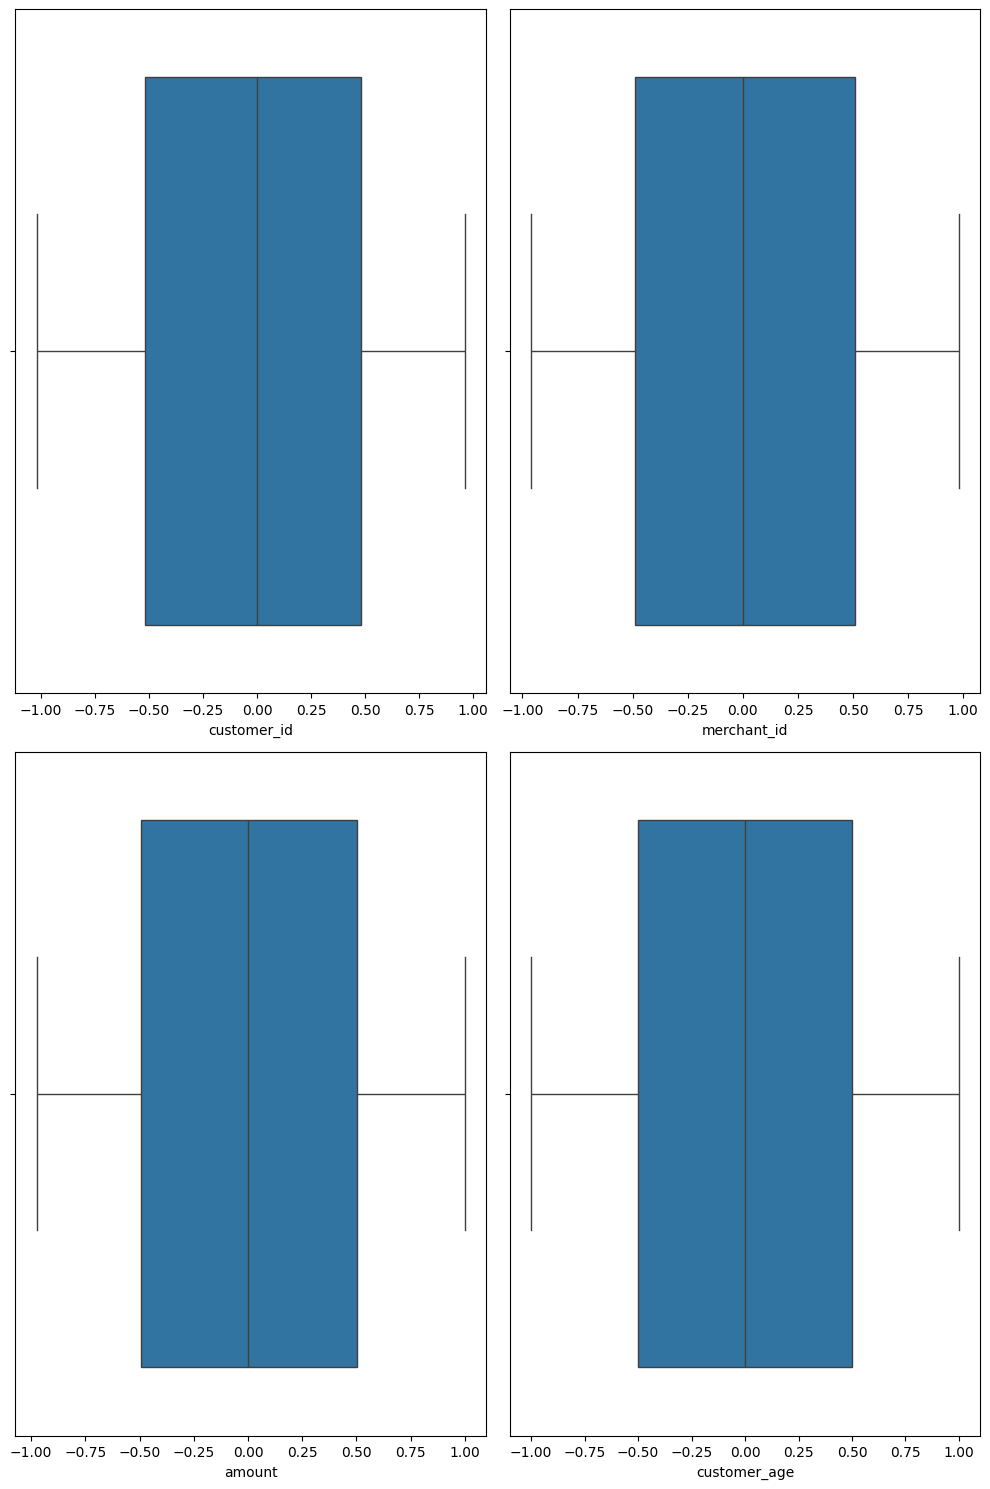

In [13]:
fig, axes = plt.subplots(nrows=2 , ncols=2, figsize = (10, 15) )

sns.boxplot(x = "customer_id", data = df, ax = axes[0][0])
sns.boxplot(x = "merchant_id", data = df, ax = axes[0][1])
sns.boxplot(x = "amount", data = df, ax = axes[1][0])
sns.boxplot(x = "customer_age", data = df, ax = axes[1][1])

plt.tight_layout()

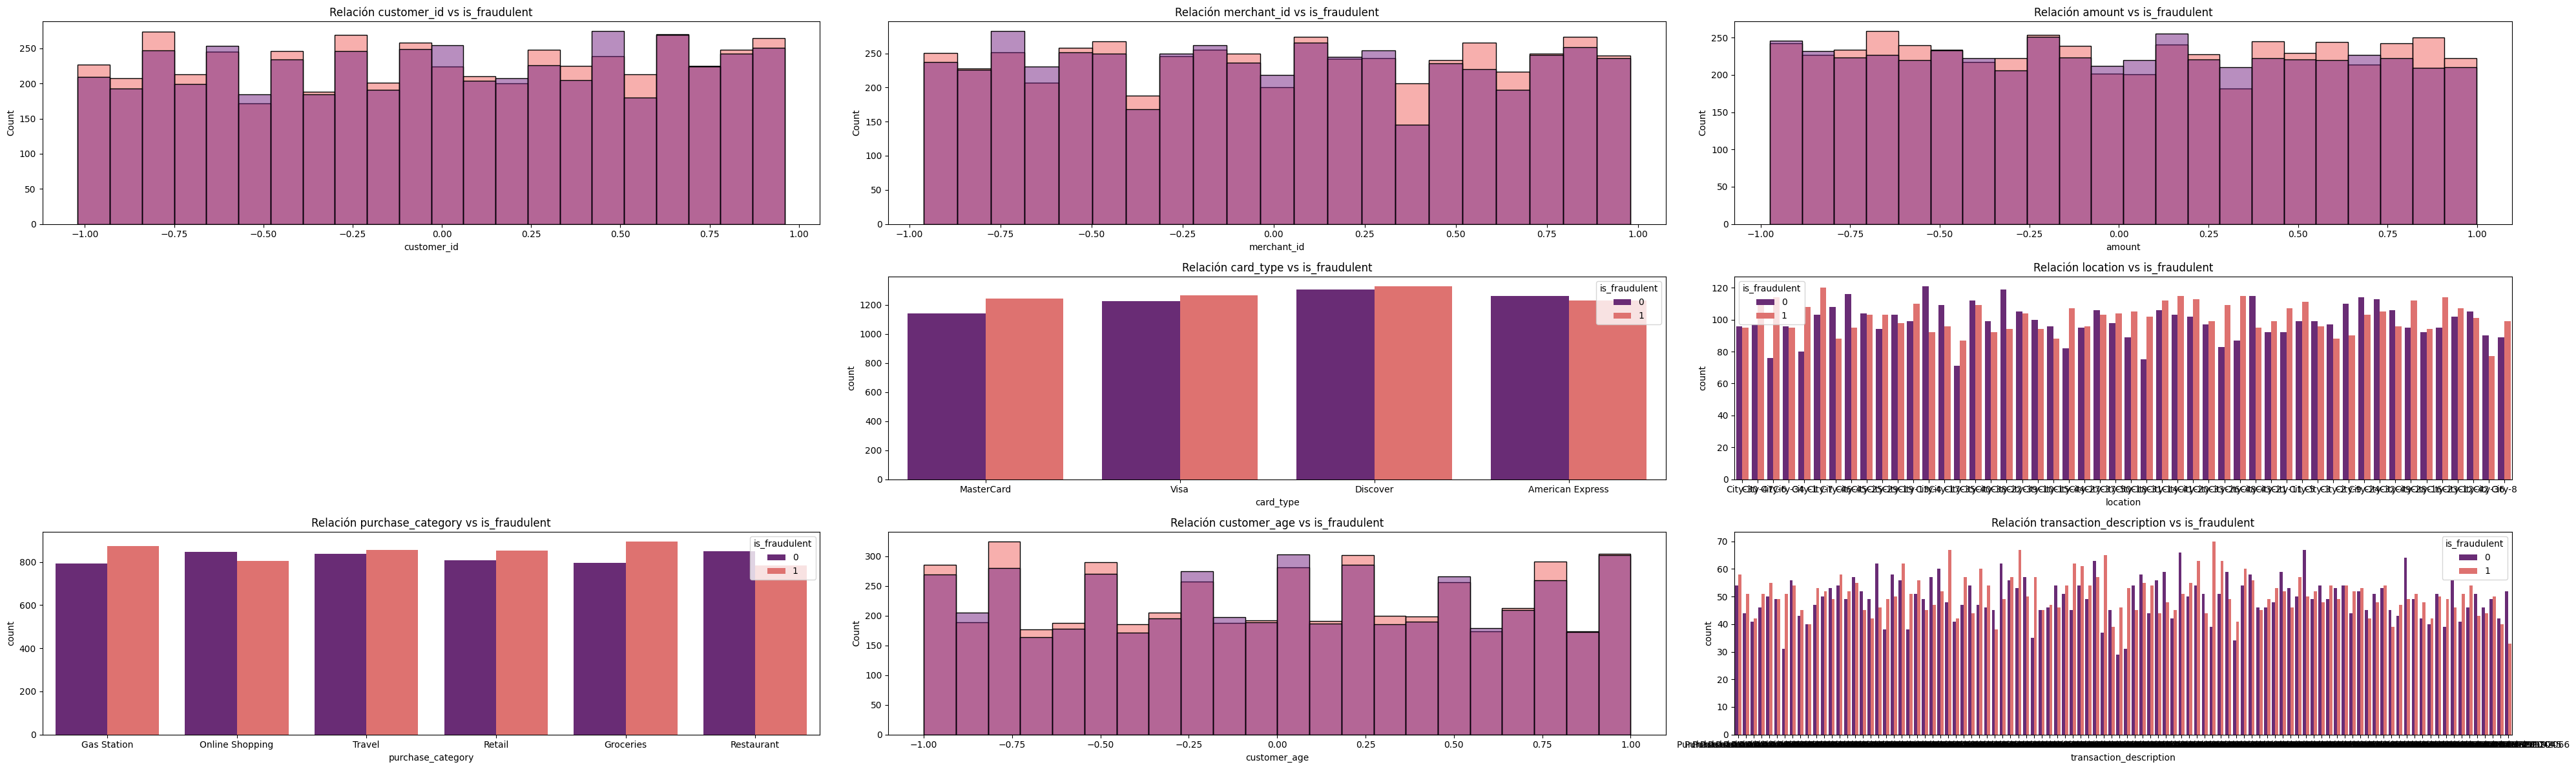

In [14]:
# evaluamos la relación entre las variables independientes y dependientes
visualizador.plot_relacion(vr = "is_fraudulent")

In [15]:
# primero vamos a sacar los nombres de las columnas que son de tipo categórico
lista_col_categ = df.select_dtypes(include = "O").columns.tolist()
lista_col_categ

['card_type', 'location', 'purchase_category', 'transaction_description']

In [16]:
# sacamos la lista de columnas categóricas
lista_col_categ = df.select_dtypes(include = ["O", "category"])

for columna in lista_col_categ:

    print(f"Analizando la relación entre is_fraudulent y {columna.upper()}")
    # Inicializar la clase
    analisis_chi2 = se.AnalisisChiCuadrado(df, variable_predictora = columna, variable_respuesta = 'is_fraudulent')

    # Generar la tabla de contingencia
    tabla_contingencia = analisis_chi2.generar_tabla_contingencia()

    # Realizar la prueba de Chi-cuadrado
    resultado_chi2 = analisis_chi2.realizar_prueba_chi_cuadrado()

    print("\n ##################################### \n")

Analizando la relación entre is_fraudulent y CARD_TYPE
Tabla de contingencia:


card_type,American Express,Discover,MasterCard,Visa
is_fraudulent,,,,
0,1262,1304,1140,1226
1,1232,1329,1243,1264



Resultado de la prueba de Chi-cuadrado:
Chi2: 3.7812082706660246, p-valor: 0.28607950351317196
El p-valor >= 0.05, no hay diferencias entre los grupos.

 ##################################### 

Analizando la relación entre is_fraudulent y LOCATION
Tabla de contingencia:


location,City-1,City-10,City-11,City-12,City-13,City-14,City-15,City-16,City-17,City-18,...,City-46,City-47,City-48,City-49,City-5,City-50,City-6,City-7,City-8,City-9
is_fraudulent,,,,,,,,,,,,,,,,,,,,,
0,80,100,92,102,99,106,96,92,109,89,...,108,97,87,106,99,98,76,103,89,110
1,108,94,107,107,110,112,88,94,96,105,...,88,109,115,96,111,104,114,120,99,90



Resultado de la prueba de Chi-cuadrado:
Chi2: 57.82620144183307, p-valor: 0.18154121719730704
El p-valor >= 0.05, no hay diferencias entre los grupos.

 ##################################### 

Analizando la relación entre is_fraudulent y PURCHASE_CATEGORY
Tabla de contingencia:


purchase_category,Gas Station,Groceries,Online Shopping,Restaurant,Retail,Travel
is_fraudulent,,,,,,
0,792,796,847,851,808,838
1,874,896,804,785,853,856



Resultado de la prueba de Chi-cuadrado:
Chi2: 13.291965751690256, p-valor: 0.020791075460818598
El p-valor < 0.05, parece que hay diferencias entre los grupos.

 ##################################### 

Analizando la relación entre is_fraudulent y TRANSACTION_DESCRIPTION
Tabla de contingencia:


transaction_description,Purchase at Merchant-2001,Purchase at Merchant-2002,Purchase at Merchant-2003,Purchase at Merchant-2004,Purchase at Merchant-2005,Purchase at Merchant-2006,Purchase at Merchant-2007,Purchase at Merchant-2008,Purchase at Merchant-2009,Purchase at Merchant-2010,...,Purchase at Merchant-2091,Purchase at Merchant-2092,Purchase at Merchant-2093,Purchase at Merchant-2094,Purchase at Merchant-2095,Purchase at Merchant-2096,Purchase at Merchant-2097,Purchase at Merchant-2098,Purchase at Merchant-2099,Purchase at Merchant-2100
is_fraudulent,,,,,,,,,,,,,,,,,,,,,
0,45,59,46,49,38,54,46,45,35,46,...,51,58,47,49,54,59,53,44,58,29
1,42,52,54,52,51,44,45,38,57,44,...,43,56,60,54,61,48,46,52,55,46



Resultado de la prueba de Chi-cuadrado:
Chi2: 91.50030498460147, p-valor: 0.6912371762337383
El p-valor >= 0.05, no hay diferencias entre los grupos.

 ##################################### 



# Enocnding

In [17]:
lista_col_categ = df.select_dtypes(include = "O").columns.tolist()
lista_col_categ 

['card_type', 'location', 'purchase_category', 'transaction_description']

In [18]:
valores_unicos = {}

# Iterar a través de las columnas categóricas y obtener los valores únicos
for col in lista_col_categ:
    valores_unicos[col] = df[col].unique().tolist()

# Mostrar los valores únicos
for col, valores in valores_unicos.items():
    print(f"Columna: {col}")
    print(f"Valores únicos: {valores}\n")

Columna: card_type
Valores únicos: ['MasterCard', 'Visa', 'Discover', 'American Express']

Columna: location
Valores únicos: ['City-30', 'City-47', 'City-6', 'City-34', 'City-1', 'City-7', 'City-46', 'City-45', 'City-25', 'City-29', 'City-19', 'City-13', 'City-4', 'City-17', 'City-35', 'City-40', 'City-38', 'City-22', 'City-39', 'City-10', 'City-15', 'City-44', 'City-27', 'City-37', 'City-50', 'City-18', 'City-31', 'City-14', 'City-41', 'City-20', 'City-33', 'City-26', 'City-48', 'City-43', 'City-21', 'City-11', 'City-5', 'City-3', 'City-2', 'City-9', 'City-24', 'City-32', 'City-49', 'City-28', 'City-16', 'City-23', 'City-12', 'City-42', 'City-36', 'City-8']

Columna: purchase_category
Valores únicos: ['Gas Station', 'Online Shopping', 'Travel', 'Retail', 'Groceries', 'Restaurant']

Columna: transaction_description
Valores únicos: ['Purchase at Merchant-2027', 'Purchase at Merchant-2053', 'Purchase at Merchant-2035', 'Purchase at Merchant-2037', 'Purchase at Merchant-2083', 'Purchase a

In [35]:
diccionario_encoding = { "target": ['card_type', "location", "transaction_description"] , 
                        "onehot": ["purchase_category"]} 
# En caso de que queramos aplicar el método solo a una columna
encoding = se.Encoding(df, variable_respuesta="is_fraudulent", diccionario_encoding=diccionario_encoding)
df = encoding.one_hot_encoding()
df = encoding.target_encoding()
df.head()

,customer_id,merchant_id,amount,is_fraudulent,card_type,location,customer_age,transaction_description,purchase_category_0.4798288508557457,purchase_category_0.48697758933979407,purchase_category_0.5053128689492326,purchase_category_0.5135460565924143,purchase_category_0.524609843937575,purchase_category_0.5295508274231678
0,0.60,-0.450980,0.160961,0,0.521611,0.497382,-0.038462,0.517857,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.74,0.058824,-0.601127,1,0.507631,0.529126,0.653846,0.536825,0.0,1.0,0.0,0.0,0.0,0.0
2,-0.96,-0.294118,-0.730090,1,0.521611,0.600000,0.500000,0.506024,0.0,0.0,0.0,0.0,1.0,0.0
3,0.86,-0.254902,0.528558,1,0.504747,0.600000,0.576923,0.525765,0.0,0.0,1.0,0.0,0.0,0.0
4,-0.32,0.647059,-0.603391,1,0.521611,0.497382,-0.307692,0.523810,0.0,0.0,0.0,1.0,0.0,0.0


In [36]:
df.to_pickle('datos/financial_data.pkl')